In [1]:
!pip install geopandas
!pip install earthpy
!pip install shapesimilarity

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 39.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 16.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

# import necessary packages
import os
import cv2
import warnings
import matplotlib.pyplot as plt
from difflib import SequenceMatcher
import geopandas as gpd
import earthpy as et
import numpy as np
import pandas as pd
import shapely
import random
import math
from shapesimilarity import shape_similarity
from scipy.spatial import procrustes
from scipy.spatial.distance import directed_hausdorff

# view the spatial extent
#print(sjer_plot_locations.total_bounds)
#print(sjer_plot_locations.crs)
#print(sjer_plot_locations.geom_type)

# plot the data using geopandas .plot() method
#fig, ax = plt.subplots(figsize = (10,10))
#(sjer_plot_locations).plot(ax=ax)
#plt.show()

Mounted at /content/gdrive


In [3]:
# import shapefile using geopandas, geopandas.geodataframe.GeoDataFrame
map = gpd.read_file('/content/gdrive/MyDrive/ZSchool_Projects/Purdue/Fun/WorldleScore/World_Countries_(Generalized)')
popularity_data = pd.read_csv("/content/gdrive/MyDrive/ZSchool_Projects/Purdue/Fun/WorldleScore/CountryPopularityData.csv")

with warnings.catch_warnings():
  warnings.simplefilter("ignore")

  skip_countries = ["American Samoa", "Anguilla", "Antarctica", "Aruba", "Azores", "Bermuda", "Bonaire", "Bouvet Island", "British Indian Ocean Territory", "British Virgin Islands", "Canarias", "Cayman Islands", "Christmas Island", "Cocos Islands", "Cook Islands", "Curacao", "Falkland Islands", "Faroe Islands", "French Guiana", "French Polynesia", "French Southern Territories", "Gibraltar", "Glorioso Islands", "Greenland", "Guadeloupe", "Guam", "Guernsey", "Heard Island and McDonald Islands", "Isle of Man", "Jersey", "Juan De Nova Island", "Madeira", "Martinique", "Mayotte", "Montserrat", "New Caledonia", "Niue", "Norfolk Island", "Northern Mariana Islands", "Palestinian Territory", "Pitcairn", "Puerto Rico", "Réunion", "Saba", "Saint Barthelemy", "Saint Eustatius", "Saint Helena", "Saint Martin", "Saint Pierre and Miquelon", "Sint Maarten", "South Georgia and South Sandwich Islands", "Svalbard", "Tokelau", "Turks and Caicos Islands", "United States Minor Outlying Islands", "US Virgin Islands", "Wallis and Futuna"]

  for i in range(len(popularity_data["Country"])):
    popularity_data["Country"][i] = popularity_data["Country"][i].replace('\n', ' ')
  
  map["COUNTRY"][np.where(map["COUNTRY"] == "Brunei Darussalam")[0][0]] = "Brunei"
  map["COUNTRY"][np.where(map["COUNTRY"] == "Cabo Verde")[0][0]] = "Cape Verde"
  map["COUNTRY"][np.where(map["COUNTRY"] == "Congo")[0][0]] = "Republic of the Congo"
  map["COUNTRY"][np.where(map["COUNTRY"] == "Congo DRC")[0][0]] = "Democratic Republic of the Congo"
  map["COUNTRY"][np.where(map["COUNTRY"] == "Côte d'Ivoire")[0][0]] = "Ivory Coast"
  map["COUNTRY"][np.where(map["COUNTRY"] == "Micronesia")[0][0]] = "Federated States of Micronesia"
  map["COUNTRY"][np.where(map["COUNTRY"] == "Russian Federation")[0][0]] = "Russia"
  map["COUNTRY"][np.where(map["COUNTRY"] == "Sao Tome and Principe")[0][0]] = "São Tomé and Príncipe"
  map["COUNTRY"][np.where(map["COUNTRY"] == "Timor-Leste")[0][0]] = "East Timor"
  map["COUNTRY"][np.where(map["COUNTRY"] == "Turkiye")[0][0]] = "Turkey"

  index_droplist = [np.where(map["COUNTRY"] == this_country)[0][0] for this_country in skip_countries]
  map = map.drop(index_droplist)

  skip_countries2 = ["Taiwan", "Kosovo"]
  index_droplist2 = [np.where(popularity_data["Country"] == this_country)[0][0] for this_country in skip_countries2]
  popularity_data = popularity_data.drop(index_droplist2)

  assert set(list(map["COUNTRY"])) == set(list(popularity_data["Country"]))


In [4]:
def name_similarity(a, b):
  # Returns score for string similarity from 0 to 1
  a = a.lower()
  b = b.lower()
  if a < b:
    a, b = b, a
  if a == b:
    return 1
  elif a in b or b in a:
    return (1 + SequenceMatcher(None, a, b).ratio()) / 2
  else:
    return (SequenceMatcher(None, a, b).ratio()) / 2

def _get_point_bounds(points):
  # Returns area of exterior square to country outline
  points = np.array(points)
  width = np.max(points[:,0]) - np.min(points[:,0])
  height = np.max(points[:,1]) - np.min(points[:,1])

  return width * height

def get_points(map, country_name, threshold=20, include_print=False):
  # Returns np array of points of country's major landmasses
  try:
    index = np.where(map["COUNTRY"] == country_name)[0][0]
    this_country = map.iloc[index:index+1]["geometry"]
  except:
    similarities = [name_similarity(each_country, country_name) for each_country in map["COUNTRY"]]
    index = similarities.index(max(similarities))
    this_country = map.iloc[index:index+1]["geometry"]
    if include_print:
      print("Interpretting as", list(map.iloc[index:index+1]["COUNTRY"])[0])
  a = []
  if type(this_country.tolist()[0]) is shapely.geometry.multipolygon.MultiPolygon:
    for polygon in this_country.tolist()[0].geoms:
      a.append(list(polygon.exterior.coords))
  else:
    a.append(list(this_country.tolist()[0].exterior.coords))
    
  biggest_landmass_len = max([_get_point_bounds(landmass) for landmass in a])

  for landmass_idx in range(len(a)):
    if _get_point_bounds(a[landmass_idx]) * threshold < biggest_landmass_len:
      a[landmass_idx] = []

  if include_print:
    return list(map.iloc[index:index+1]["COUNTRY"])[0]

  return np.array([j for i in a for j in i])

def get_outline(map, country_name, threshold=20):
  # Returns separate x and y coords excluding small landmasses
  try:
    index = np.where(map["COUNTRY"] == country_name)[0][0]
    this_country = map.iloc[index:index+1]["geometry"]
  except:
    similarities = [name_similarity(each_country, country_name) for each_country in map["COUNTRY"]]
    index = similarities.index(max(similarities))
    this_country = map.iloc[index:index+1]["geometry"]
  a = []
  if type(this_country.tolist()[0]) is shapely.geometry.multipolygon.MultiPolygon:
    for polygon in this_country.tolist()[0].geoms:
      a.append(list(polygon.exterior.coords))
  else:
    a.append(list(this_country.tolist()[0].exterior.coords))
    
  biggest_landmass_len = max([_get_point_bounds(landmass) for landmass in a])

  for landmass_idx in range(len(a)):
    if _get_point_bounds(a[landmass_idx]) * threshold < biggest_landmass_len:
      a[landmass_idx] = []

  x_coords = np.array([j[0] for i in a for j in i])
  y_coords = np.array([j[1] for i in a for j in i])

  return x_coords, y_coords

def get_center(map, country):
  return np.mean(get_points(map, country), axis=0)

def plot_country(country_list, point_list):
  # Plots each country and point in input lists
  for country in country_list:
    plt.scatter(country[:,0], country[:,1], s=1)
  for point in point_list:
    plt.scatter(point[0], point[1])

def get_true_center(map, country):
  # Gets center for evenly spaced points
  points = get_points(map, country)
  point_list = points.tolist()
  skip_points = []
  keep_points = []
  threshold = np.sqrt(_get_point_bounds(points)) / 6

  for idx in range(len(points)):
    if (point_list[idx] not in skip_points):
      keep_points.append(point_list[idx])
      dist_list = np.sqrt(((points[:,0] - points[idx][0]))**2 + ((points[:,1] - points[idx][1])**2))
      for idx2 in range(len(points)):
        if dist_list[idx2] < threshold:
          skip_points.append(point_list[idx2])

  return np.median(np.array(keep_points), axis=0)

def get_popularity(popularity_data, country, include_print=False):
  # Gets popularity of country as score from 0 to 1
  try:
    index = np.where(popularity_data["Country"] == country)[0][0]
    this_country = popularity_data.iloc[index:index+1]["Popularity"]
  except:
    similarities = [name_similarity(each_country, country) for each_country in popularity_data["Country"]]
    index = similarities.index(max(similarities))
    if include_print:
      print("Interpretting as", str(popularity_data["Country"][index]))
    this_country = popularity_data.iloc[index:index+1]["Popularity"]

  return 1 - (float(this_country) / 100)

def get_min_distance(map, country1, country2):
  # Finds min distance between countries
  points1 = get_points(map, country1)
  points2 = get_points(map, country2)
  center1 = get_true_center(map, country1)
  center2 = get_true_center(map, country2)

  closestP1 = points1[0]
  min_dist = 1e6

  for i in range(len(points1)):
    dist = np.linalg.norm(points1[i] - center2)
    if dist < min_dist:
      min_dist = dist
      closestP1 = points1[i]

  closestP2 = points2[0]
  min_dist2 = 1e6

  for i in range(len(points2)):
    dist = np.linalg.norm(points2[i] - closestP1)
    if dist < min_dist2:
      min_dist2 = dist
      closestP2 = points2[i]

  return 111.1 * min_dist2

def get_angle_twixt_countries(map, country1, country2):
  # Finds angle between country centers
  center1 = get_true_center(map, country1)
  center2 = get_true_center(map, country2)

  width = center2[0] - center1[0]
  height = center2[1] - center1[1]
  
  angle = math.atan(height / width) * 180 / math.pi

  if width < 0 and height < 0:
    offset = -180
  elif width < 0 and height > 0:
    offset = 180
  else:
    offset = 0

  return angle + offset

def get_direction(map, country1, country2):
  # Returns cardinal direction based on angle
  angle = get_angle_twixt_countries(map, country1, country2)
  if angle > -157.5 and angle < -112.5:
    return "NE"
  elif angle > -112.5 and angle < -67.5:
    return "N"
  elif angle > -67.5 and angle < -22.5:
    return "NW"
  elif angle > -22.5 and angle < 22.5:
    return "W"
  elif angle > 22.5 and angle < 67.5:
    return "SW"
  elif angle > 67.5 and angle < 112.5:
    return "S"
  elif angle > 112.5 and angle < 157.5:
    return "SE"
  else:
    return "E"

def get_size_similarity(map, country1, country2, include_print=False):
  # Gets size similarity as score 0 to 1
  try:
    index = np.where(map["COUNTRY"] == country1)[0][0]
    area1 = float(map.iloc[index:index+1]["SHAPE_Area"])
  except:
    similarities = [name_similarity(each_country, country1) for each_country in map["COUNTRY"]]
    index = similarities.index(max(similarities))
    if include_print:
      print("Interpretting as", str(popularity_data["Country"][index]))
    area1 = float(map.iloc[index:index+1]["SHAPE_Area"])

  try:
    index2 = np.where(map["COUNTRY"] == country2)[0][0]
    area2 = float(map.iloc[index2:index2+1]["SHAPE_Area"])
  except:
    similarities = [name_similarity(each_country, country2) for each_country in map["COUNTRY"]]
    index2 = similarities.index(max(similarities))
    if include_print:
      print("Interpretting as", str(popularity_data["Country"][index2]))
    area2 = float(map.iloc[index2:index2+1]["SHAPE_Area"])

  score = max(1 - (np.abs(area1 - area2) / 125), 0)

  return score

def get_shape_similarity(map, country1, country2, show_plot=False, cutoff=1):
  # Gets shape similarity as score 0 to 1
  points1 = get_points(map, country1)
  points2 = get_points(map, country2)
  
  width1, height1 = max(points1[:,0]) - min(points1[:,0]), max(points1[:,1]) - min(points1[:,1])
  width2, height2 = max(points2[:,0]) - min(points2[:,0]), max(points2[:,1]) - min(points2[:,1])

  points1[:,0] *= width2 / width1
  points1[:,1] *= height2 / height1

  offset_width = min(points1[:,0]) - min(points2[:,0])
  offset_height = min(points1[:,1]) - min(points2[:,1])

  points2[:,0] += offset_width
  points2[:,1] += offset_height

  num_points = min(len(points1), len(points2), 5000)

  points1 = points1[np.random.choice(points1.shape[0], num_points, replace=False)]
  points2 = points2[np.random.choice(points2.shape[0], num_points, replace=False)]

  if show_plot:
    plt.scatter(points1[:,0], points1[:,1])
    plt.scatter(points2[:,0], points2[:,1])
    plt.axis('off')

  if directed_hausdorff(points1, points2)[0] == 0:
    return 1

  return min(cutoff, 1 / (5 * (directed_hausdorff(points1, points2)[0] / min(width2, height2))))

def superscore(map, popularity_data, c1, c2, weights = [100, 50, 10, 10, 5, 5]):
  # Computes weighted average of scores
  dist_score = max(1 - (get_min_distance(map, c1, c2) / 11110), 0)
  shape_score = get_shape_similarity(map, c1, c2)
  name_score = name_similarity(c1, c2)
  size_score = get_size_similarity(map, c1, c2)
  pop1 = get_popularity(popularity_data, c1)
  pop2 = get_popularity(popularity_data, c2)

  scores = [dist_score, shape_score, name_score, size_score, pop1, pop2]

  print(scores)
  
  final_score = 0
  weight_sum = 0
  
  for i in range(len(scores)):
    final_score += scores[i] * weights[i]
    weight_sum += weights[i]

  final_score /= weight_sum

  return final_score

In [5]:
superscore(map, popularity_data, "Guyana", "china")

[0, 0.4767941052526896, 0.18181818181818182, 0, 0.56, 0.050000000000000044]


0.15948826156009058

In [6]:
def main():
  country = random.choice(list(map["COUNTRY"]))
  x, y = get_outline(map, country)
  points = get_points(map, country)
  width = max(points[:,0]) - min(points[:,0])
  height = max(points[:,1]) - min(points[:,1])
  plt.rcParams['figure.figsize'] = (3, (3 / width) * height)
  plt.plot(x, y)
  plt.axis('off')
  plt.show()

  guess = ""
  i = 1
  scores = []
  is_first_guess = True

  while True:
    guess = input(f"Enter guess {i}: ")
    p = get_points(map, guess, include_print=True)
    if p == country:
      break
    if is_first_guess:
      is_first_guess = False
      scores.append(superscore(map, popularity_data, country, guess, weights=[0, 50, 10, 10, 5, 5]))
    else:
      scores.append(superscore(map, popularity_data, country, guess))

    distance = round(get_min_distance(map, guess, country), 2)
    print(f"Distance (km): {distance} ({round(100 - (100 * distance / 11110), 2)}%)")
    print("Direction:", get_direction(map, country, guess))
    print()
    i += 1
  print("That's correct!")

  print("Final scores: ", scores)
  print("Final score: ", np.mean(np.array(scores)))

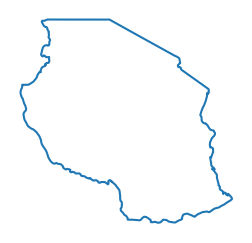

Enter guess 1: algeria
Interpretting as Algeria
[0.6923385864070135, 0.7625365120818506, 0.2, 0, 0.55, 0.36]
Distance (km): 3418.1 (69.23%)
Direction: SE

Enter guess 2: somalia
Interpretting as Somalia
[0.9602280437294899, 0.37127848822230547, 0.2, 0.800492994062349, 0.55, 0.4]
Distance (km): 423.28 (96.19%)
Direction: SW

Enter guess 3: kenya
Interpretting as Kenya
[1.0, 0.9943101239494637, 0.07692307692307693, 0.7623845914423646, 0.55, 0.4]
Distance (km): 0.0 (100.0%)
Direction: SW

Enter guess 4: rwanda
Interpretting as Rwanda
[0.9992681169465537, 0.8101662483821723, 0.21428571428571427, 0.4002768336085043, 0.55, 0.6]
Distance (km): 0.0 (100.0%)
Direction: SE

Enter guess 5: tanzania
Interpretting as Tanzania
That's correct!
Final scores:  [0.5584603200511566, 0.7185647706927097, 0.9047699048951533, 0.846281942181701]
Final score:  0.7570192344551802


In [7]:
main()